In [1]:
import sys
# sys.path.append('../')
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.ModelData.particle import Particle, Neutron


In [2]:
sammypath = "/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy"

In [3]:
%matplotlib widget

# Define generative models

Neutron induced reaction measurements using the time-of-flight method can be modelled using 3 primary categories:
1. A reaction model, represented here in ATARI the Particle_Pair class
2. An experimental model, represented here in ATARI by the Experimental_Model class
3. A reduction model, represented in ATARI by a Reduction_Model protocol

These three models attempt to describe everything that is happenning in one of these experiments. 
Traditionally, these models are used to analyze experimental data. 
The Syndat module of the ATARI code uses these models in a generative manner, producing statistical samples of experimental data.


## Reaction Model: Particle Pair class
Each of the 3 models can also be created outside and then added to the Generative Model container.
These ATARI classes have additional functionality if you want to work with them at this lower level.
The following code snippet demonstrates some of these capabilities.

In [4]:
Ta181 = Particle(Z=73, A=181, I=3.5, mass=180.94803, name='Ta181')
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,250],
                        ac = 0.8127,
                        target=Ta181,
                        projectile=Neutron,
                        l_max = 1
)

# print quant number map up to l_max
Ta_pair.map_quantum_numbers(print_out=True)

# J = 3, <D> = 9.0030 eV, <gn2> = 452.56615 meV, <gg2> = 32.0 meV
# J = 4, <D> = 8.3031 eV, <gn2> = 332.24347 meV, <gg2> = 32.0 meV

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, #46.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, #35.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

print()
print("Interrogate spin group attribute:")
print(Ta_pair.spin_groups[3.0])


print()
print("Resonance ladder sampled from resonance statistics:")
print(Ta_pair.sample_resonance_ladder())


Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])

Interrogate spin group attribute:
{'Jpi': 3.0, 'J_ID': 1, '<D>': 9.003, '<gn2>': 452.56615, 'n_dof': 1, '<gg2>': 32.0, 'g_dof': 1000, 'quantiles': {'D01': 1.0184333135415622, 'D99': 21.80043460630884, 'gn01': 0.0710926470659408, 'gn99': 3002.729610372257, 'gg01': 28.765198301747624, 'gg99': 35.42300781927096, 'gt01': 28.836290948813566, 'gt99': 3038.152618191528}, 'chs': 1, 'Ls': [0]}

Resonance ladder sampled from resonance statistics:
            E         Gg        Gn1  J_ID        gg2          gn2  Jpi    L
0  208.287782  63.351018  35.133407   1.0  31.675509   685.567545  3.0  0.0
1  218.330350  64.714747   1.420698   1.0  32.357374    27.077371  3.0  0.0
2  219.844065  66.068906  52.835884   1.0  33.034453  1003.537227  3.0  0.0
3  227.141633  60.927451   2.355117   1.0  30.463725    44.007436  3.0  0.0
4  234.599856  65.851611  25.068

## Experimental Model class & Sammy

This class's primary purpose is to hold relevant experimental information used in calculating experimentally corrected resonance models with SAMMY.
The ATARI code come with a sammy-interface module that wraps around the sammy code. For more details on this interface, see the user example notebook. 
Before the Experimental_Model can be passed to syndat, the user must define the template parameter to be a path to a sammy input template. 

The sammy interface has a module for creating template input files from these generative models. 
The idea is that you make the template, inspect it manually, then give it to the experimental model class to be used with syndat

In [5]:
Ta_pair.resonance_ladder

,E,Gg,Gn1,J_ID,gg2,gn2,Jpi,L
0,208.287782,63.351018,35.133407,1.0,31.675509,685.567545,3.0,0.0
1,218.330350,64.714747,1.420698,1.0,32.357374,27.077371,3.0,0.0
2,219.844065,66.068906,52.835884,1.0,33.034453,1003.537227,3.0,0.0
3,227.141633,60.927451,2.355117,1.0,30.463725,44.007436,3.0,0.0
4,234.599856,65.851611,25.068879,1.0,32.925805,460.927835,3.0,0.0
5,249.524334,59.772799,3.714711,1.0,29.886399,66.226299,3.0,0.0
6,205.862652,58.534142,0.249240,2.0,29.267071,4.892046,4.0,0.0
7,228.781167,62.908059,33.460589,2.0,31.454029,622.996100,4.0,0.0
8,237.553380,63.629740,37.050217,2.0,31.814870,676.974063,4.0,0.0
9,242.793170,61.110317,20.388109,2.0,30.555159,368.485669,4.0,0.0


In [6]:

trans12mm_gen_exp = Experimental_Model(title = "T12mm", 
                                 reaction = "transmission", 
                                 energy_range = [200, 250], 
                                 template = None, 
                                 energy_grid = None, 
                                 n = (0.067166, 0.0), 
                                 FP = (35.185, 0.0), 
                                 t0 = (3326.0, 0.0), 
                                 burst = (10, 1.0), 
                                 temp = (300, 0.0), 
                                 channel_widths = { 
                                     "maxE": [2500],
                                     "chw": [100.0],
                                     "dchw": [0.8]
                                 }
)

cap12mm_gen_exp = Experimental_Model(title = "Y12mm", 
                                 reaction = "capture", 
                                 energy_range = [200, 250], 
                                 template = None, 
                                # template = os.path.realpath("/Users/noahwalton/Documents/GitHub/ATARI/ATARI/sammy_interface/sammy_templates/allexpcap_1sg.inp"),
                                 energy_grid = None, 
                                 n = (0.067166, 0.0), 
                                 FP = (35.185, 0.0), 
                                 t0 = (3326.0, 0.0), 
                                 burst = (10, 1.0), 
                                 temp = (300, 0.0), 
                                 channel_widths = { 
                                     "maxE": [250],
                                     "chw": [100.0],
                                     "dchw": [0.8]
                                 }
)


sammy_rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T.inp', Ta_pair, trans12mm_gen_exp, sammy_rto)

template_creator.make_input_template(
    'template_Y.inp', Ta_pair, cap12mm_gen_exp, sammy_rto)


cap12mm_gen_exp.template = os.path.realpath('template_Y.inp')

trans12mm_gen_exp.template = os.path.realpath('template_T.inp')

In [7]:
cap12mm_gen_exp.sammy_inputs

{'alphanumeric': ['USE MULTIPLE SCATTERING',
  'INFINITE SLAB',
  'NORMALIZE AS YIELD Rather than cross section',
  'BROADENING IS WANTED',
  'DO NOT SHIFT RPI RESOLUTION'],
 'ResFunc': 'RPI C'}

## Measurement models

Syndat needs both a generative and reductive measurement model. 
The generative model is considered 'true' and is used to generate statistical samples of raw experimental observables. 
These raw observables, however, are not used directly in evaluations, rather they are put through a data reduction model to get an object like experimental transmission or capture yield. 
By defining both a generative and reductive measurment model, Syndat can be used to investigate the impact of incorrectly specified measurement models/parameters used in the data reduction process.



In [8]:
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT


trans12mm_gen_meas = Transmission_RPI()
trans12mm_red_meas = Transmission_RPI()

cap12mm_gen_meas = Capture_Yield_RPI()
cap12mm_red_meas = Capture_Yield_RPI()

# cap12mm_gen_meas = Capture_Yield_RPI(trig_g    = (1000000,0),
#                                      trig_bg   = (1000000,0),
#                                      trig_f    = (1000000,0),
#                                      trig_bf   = (1000000,0))
# cap12mm_red_meas = Capture_Yield_RPI(trig_g    = (1000000,0),
#                                      trig_bg   = (1000000,0),
#                                      trig_f    = (1000000,0),
#                                      trig_bf   = (1000000,0))

## Sampling from Syndat

The syndat class contains all necessary model information. 
It also takes a syndat options class which can be instantiated with default settings.
Once you've constructed your syndat model, the sample method can be used to draw any number of samples.
This method takes either a sammyRTO arguement or a pw_true arguement. 
If pw_true is given, this will be taken as the true experimental function around with measurement data will be sampled. 
Usually the user will provide a sammyRTO instead which will allow the true experimental function to be reconstructed by sammy.
This also allows new resonance ladders to be sampled each time.


In [9]:
synOPT = syndatOPT(calculate_covariance=True, save_raw_data=True)
synOPT 

calculate_covariance: True
explicit_covariance: False
sampleRES: True
sampleTMP: True
sampleTNCS: True
sampleTURP: True
sample_counting_noise: True
save_raw_data: True
smoothTNCS: False

In [10]:
synOPT.calculate_covariance = True
synOPT.explicit_covariance = True
syndat_trans12mm = Syndat_Model(trans12mm_gen_exp,
                            trans12mm_gen_meas,
                            trans12mm_red_meas,
                            options = synOPT,
                            title='trans12mm')

syndat_trans12mm.sample(Ta_pair, 
                    sammyRTO=sammy_rto,
                    num_samples=3)

synOPT.calculate_covariance = True
syndat_cap12mm = Syndat_Model(cap12mm_gen_exp,
                            cap12mm_gen_meas,
                            cap12mm_red_meas,
                            options = synOPT,
                            title='cap12mm')


syndat_cap12mm.sample(Ta_pair, 
                    sammyRTO=sammy_rto,
                    num_samples=3)

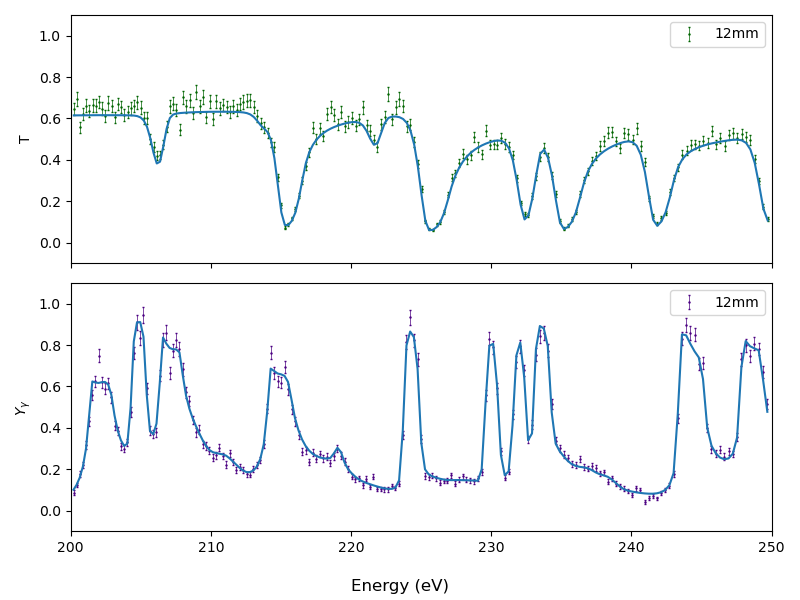

In [13]:
dataT = syndat_trans12mm.samples[0].pw_reduced
dataY = syndat_cap12mm.samples[1].pw_reduced

### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

### Trans
axes[0].errorbar(dataT.E, dataT.exp, yerr=dataT.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

axes[0].plot(dataT.E, dataT.true)
axes[0].set_ylabel("T")

# # ### Capture
axes[1].errorbar(dataY.E, dataY.exp, yerr=dataY.exp_unc, zorder=0, 
                                        fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')
axes[1].plot(dataY.E, dataY.true)

axes[1].set_ylabel(r"$Y_{\gamma}$")

# ### make it pretty
for ax in axes:
    ax.set_xlim([200,250])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

## Syndat control module for multiple datasets

The above example shows how to build and sample from a complete syndat model for one experimental dataset. 
It showcases both transmission and capture yield measurement models, however, these are not used together.
Immediately, you can see how it would be more useful to generate multiple data types from the same set of resonance parameters.

The Syndat Control Module can be used to build and sample from several correlated syndat models at once.
The default correlation between datasets is to use a common reaction model (resonance ladder) to emulate multiple measurements of the same isotope.
Generating data with the Syndat Control Module will automatically use the same resonance ladder for each syndat model you give it.
<!-- 
### First, put each of these syndat models into the control module class -->

<!-- Options can be redefined here, each respective syndat model will take on the new options. -->
<!-- 1. sample resonance ladder
For all models/datasets:
2. sample correlated parameters
3. sample uncorrelated parameters
4. generate raw data 
5. reduce raw data -->

In [14]:
from ATARI.syndat.control import Syndat_Control

syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= [syndat_trans12mm, syndat_cap12mm],
                        model_correlations=None,
                        options=synOPT
                        )

syndat.sample(sammy_rto, num_samples=2)
sample1 = syndat.get_sample(1)
sample1

{'trans12mm': <ATARI.syndat.data_classes.syndatOUT at 0x7f8930df1750>,
 'cap12mm': <ATARI.syndat.data_classes.syndatOUT at 0x7f88f8b024a0>}

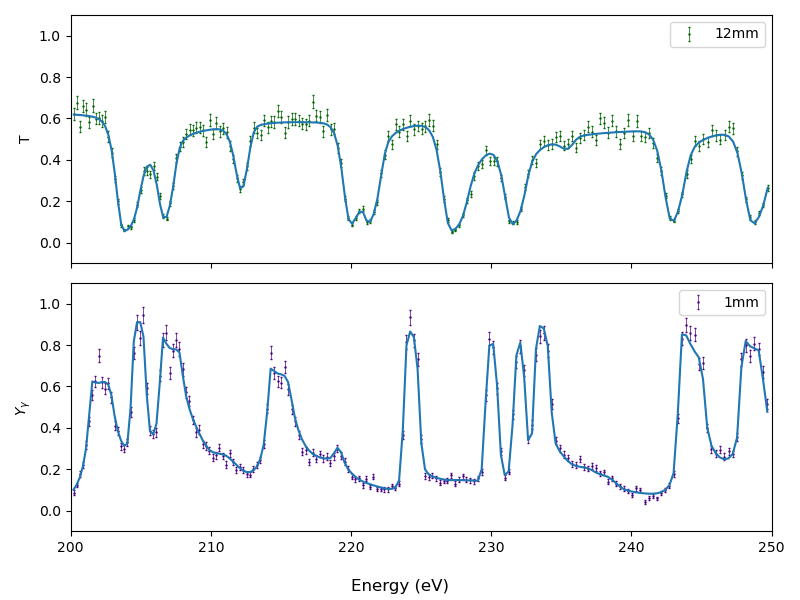

In [15]:

### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

### Trans
axes[0].errorbar(sample1['trans12mm'].pw_reduced.E, sample1['trans12mm'].pw_reduced.exp, yerr=sample1['trans12mm'].pw_reduced.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

axes[0].plot(sample1['trans12mm'].pw_reduced.E, sample1['trans12mm'].pw_reduced.true)
axes[0].set_ylabel("T")

### Capture
axes[1].errorbar(sample1['cap12mm'].pw_reduced.E, sample1['cap12mm'].pw_reduced.exp, yerr=sample1['cap12mm'].pw_reduced.exp_unc, zorder=0, 
                                        fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='1mm')
axes[1].plot(sample1['cap12mm'].pw_reduced.E, sample1['cap12mm'].pw_reduced.true)

axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,250])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

In [16]:
sample1['trans12mm'].covariance_data

{'CovT': E           200.219142  200.442070  200.665371  200.889046  201.113094  \
 200.219142    0.000833    0.000249    0.000206    0.000243    0.000237   
 200.442070    0.000249    0.000995    0.000225    0.000265    0.000259   
 200.665371    0.000206    0.000225    0.000696    0.000220    0.000214   
 200.889046    0.000243    0.000265    0.000220    0.000926    0.000252   
 201.113094    0.000237    0.000259    0.000214    0.000252    0.000920   
 ...                ...         ...         ...         ...         ...   
 248.479721    0.000047    0.000051    0.000042    0.000050    0.000049   
 248.787958    0.000037    0.000041    0.000034    0.000040    0.000039   
 249.096769    0.000053    0.000058    0.000048    0.000056    0.000055   
 249.406156    0.000067    0.000073    0.000061    0.000072    0.000070   
 249.716119    0.000098    0.000107    0.000089    0.000104    0.000102   
 
 E           201.337518  201.562317  201.787493  202.013047  202.238979  ...  \
 200.21914

### Correlated Experiments... Coming soon

This module also allows experimental correlations between datasets to be included, such as normalizing capture yields to the same detector yield. 
This behavior is not default and must be described in the model_correlations input.
The model_correlations input is a dictionary with keys that indicate the parameter and values that are tuples of (mean, uncertainty).
These values correspond to the measurement model parameters and, if given, 

In [17]:
# test = {'011': {'trigs':(10000,0)}}

# for i in test.keys():
#     print([int(each) for each in list(i)])


[0, 1, 1]


In [ ]:

# class model_correlation:
#     def __set_name__(self, owner, name):
#         self._name = name

#     def __get__(self, instance, owner) -> tuple:
#         return instance.__dict__[self._name]

#     def __set__(self, instance, value):
#         # instance.__dict__[self._name] = date.fromisoformat(value)
#         if isinstance(value, tuple):
#             if len(value) != 2:
#                 raise ValueError("Tuple for parameter must be (value, uncertainty)")
#         else:
#             raise ValueError("Must supply tuple for parameter value and uncertainty")
#         instance.__dict__[self._name] = value


# class model_correlation:
#     def __init__(self):
#         pass

#     self._enable = [True, True, True]
#     self._model_type = 'measurement'
#     self._parameter_key = 'ks'
#     self._parameter = (0.0563, 0.02402339737495515)

#     def sample_true_parameter(self):
        

